In [4]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

import plotly.graph_objects as go

from cfl.cluster_methods.kmeans import KMeans
from cfl.experiment import Experiment
from visual_bars import generate_visual_bars_data as vbd
from cfl.util.data_processing import one_hot_encode
from cfl.dataset import Dataset
from cfl.visualization_methods import clustering_to_sankey as sk


In [5]:
import cProfile

In [6]:
# create a visual bars data set

n_samples = 100 #1000 is too small to get good estimates from the CNN
# but it's too big to cluster in a reasonable time with SNN 

noise_lvl = 0.03
im_shape = (10, 10)
random_seed = 143
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

ims = vb_data.getImages()
y = vb_data.getTarget()

# format data
x = np.expand_dims(ims, -1)

y = one_hot_encode(y, unique_labels=[0,1])



Generating a visual bars dataset with 100 samples at noise level 0.03


In [4]:
x.shape[1:]

(10, 10, 1)

In [9]:
data_info = {'X_dims': x.shape,
             'Y_dims': y.shape,
             'Y_type': 'categorical'}

# # # paragmeters for CDE
# CNN_params = { # parameters for model creation
#                     'filters'         : [32, 16],
#                     'input_shape'     : (10, 10, 1),
#                     'kernel_size'     : [(3, 3)] *2,
#                     'pool_size'       : [(2, 2)] *2,
#                     'padding'         : ['same'] *2,
#                     'conv_activation' : ['softmax', 'softmax'],
#                     'dense_units'     : 16,
#                     'dense_activation' : 'softmax',
#                     'output_activation': 'softmax',

#                     # parameters for training
#                     'batch_size'  : 32,
#                     'n_epochs'    : 5,
#                     'optimizer'   : 'adam',
#                     'opt_config'  : {},
#                     'verbose'     : 2,
#                     'weights_path': None,
#                     'loss'        : 'mean_squared_error',
#                     'show_plot'   : True,
#                     'standardize' : False,
#                     'best'        : True,
#                     }


# block_names = ['CondExpCNN']
# block_params = [CNN_params]

# # save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
# save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test'
# my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)

# results = my_exp.train()

In [10]:
save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, results_path=save_path, past_exp_path='C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test/experiment0050')
import joblib 

results = joblib.load('C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test/experiment0050/dataset_train/CondExpCNN_results.pickle')

my_exp.blocks[0].model.summary()

All results from this run will be saved to C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test\experiment0061
Loading parameters from  C:/Users/jkahn/Documents/Schmidt Academy/cfl/cnn_test/experiment0050\trained_blocks\CondExpCNN
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 16)          4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
______________________

In [11]:
pyx = results['pyx']

pyx[:10]

array([[0.4856626 , 0.5143374 ],
       [0.48567176, 0.51432824],
       [0.48563722, 0.5143628 ],
       [0.48567256, 0.5143274 ],
       [0.4856798 , 0.51432014],
       [0.48568168, 0.51431835],
       [0.48565772, 0.5143423 ],
       [0.48565605, 0.514344  ],
       [0.4856683 , 0.51433164],
       [0.48566756, 0.5143325 ]], dtype=float32)

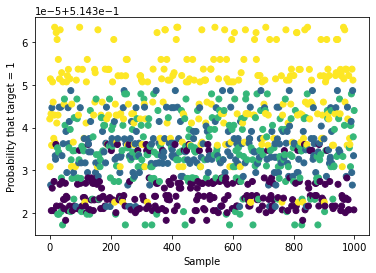

Average prediction for x-class 0: 0.49
Average prediction for x-class 1: 0.49
Average prediction for x-class 2: 0.49
Average prediction for x-class 3: 0.49


In [12]:
truth = vb_data.getGroundTruth()

#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace= True)

# plot them
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.ylabel("Probability that target = 1")
plt.xlabel("Sample")
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,0])))


In [10]:
# create a smaller visual bars data set

# n_samples = 1000
# print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

# vb_data_small = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

# ims = vb_data_small.getImages()
# y = vb_data_small.getTarget()

# # format data
# x = np.expand_dims(ims, -1)

# y = one_hot_encode(y, unique_labels=[0,1])

# new_data = Dataset(x, y)
# results = my_exp.predict(new_data)
# cde_results_dict = results['CondExpCNN']

In [13]:
from cfl.cluster_methods.snn import SNN

cluster_params = {'neighbor_num': 4, 'min_shared_neighbor_proportion' : 0.2 }
snn_obj = SNN('SNN', data_info, cluster_params, random_state=143)

cde_results_dict = results

data = Dataset(x, y)

cProfile.run('snn_obj.train(data, cde_results_dict["pyx"])', sort='tottime')




name specified but not used by SNN
         93042 function calls (93008 primitive calls) in 0.196 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.025    0.012    0.177    0.088 snn_helper.py:35(snn)
     1211    0.015    0.000    0.015    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     9900    0.015    0.000    0.025    0.000 snn_helper.py:87(get_snn_distance)
     3936    0.011    0.000    0.011    0.000 {built-in method numpy.array}
      804    0.008    0.000    0.022    0.000 sputils.py:119(get_index_dtype)
     9900    0.006    0.000    0.006    0.000 {method 'intersection' of 'set' objects}
     1608    0.006    0.000    0.006    0.000 getlimits.py:498(__init__)
      200    0.005    0.000    0.024    0.000 coo.py:265(_check)
2233/2229    0.005    0.000    0.022    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      202    0.004    0.000    0.020    0.000 compressed

In [13]:
res = snn_obj.train(data, cde_results_dict["pyx"])

In [11]:
compare = joblib.load('compare.pkl')

In [15]:
res[0]

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [16]:
compare[0]

array([[0. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 0. , 1. , ..., 0.5, 1. , 1. ],
       [1. , 1. , 0. , ..., 1. , 1. , 1. ],
       ...,
       [1. , 0.5, 1. , ..., 0. , 1. , 1. ],
       [1. , 1. , 1. , ..., 1. , 0. , 1. ],
       [1. , 1. , 1. , ..., 1. , 1. , 0. ]])

In [9]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(truth, res['x_lbls'])


TypeError: tuple indices must be integers or slices, not str

In [53]:
# create a number of Kmeans objects with different Ks
k_range = range(2, 8)

kmeans_l = []
for n_clusters in k_range:
    params = {'n_Xclusters': n_clusters, 'n_Yclusters': 2}
    kmeans_obj = KMeans('Kmeans', data_info, params, random_state=143)
    kmeans_l.append(kmeans_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss
x_lbls_L = []
for kmeans_obj in kmeans_l:
  cluster_results = kmeans_obj.train(data, cde_results_dict)
  x_lbls_L.append(cluster_results['x_lbls'])


In [56]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])

fig.update_layout(title_text="Visual Bars Clustering, noise=0.03, with 2 to 7 Clusters", font_size=10)
fig.show()

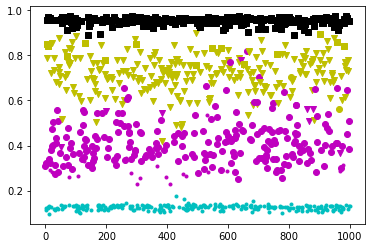

In [77]:
truth = vb_data.getGroundTruth()

# graph the 4 actual clusters against 4 predicted clusters 

# plot them
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['c','m', 'y', 'k', 'r', 'g','b']

#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample
for i in range(1000):
    pi = pyx[plot_idx[i],1] # plot probability
    mi = markers[x_lbls_L[2][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci)
plt.show()



In [ ]:
from cfl.visualization_methods import general_vis as vis

vis.view_class_examples(ims, im_shape, 10, x_lbls_L[0])


In [ ]:
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[1])


# # %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[2])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[3])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[4])


# %%
# vis.view_class_examples(ims, im_shape, 10, x_lbls_L[5])



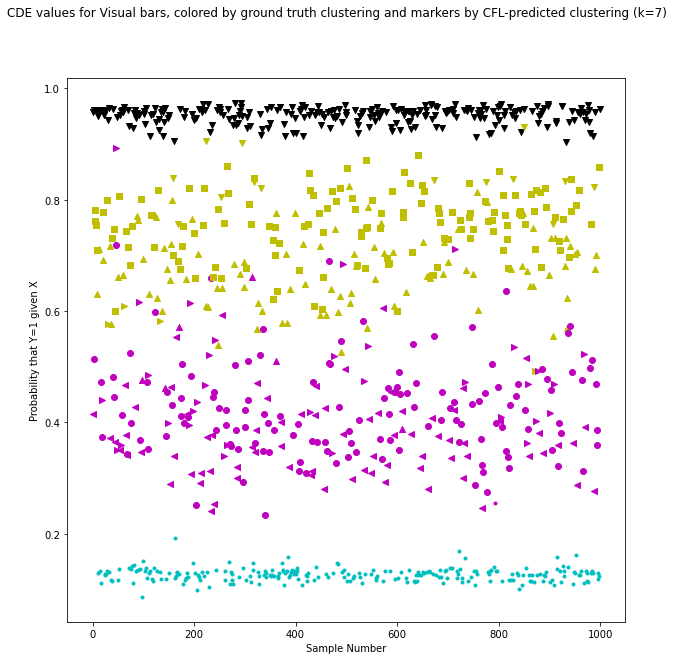

In [82]:
truth = vb_data.getGroundTruth()


# plot them
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['c','m', 'y', 'k', 'r', 'g','b']


#choose a thousand random samples from the pyx results
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample
fig = plt.figure(figsize=(10, 10))
for i in range(1000):
    pi = pyx[plot_idx[i],1] # plot probability
    mi = markers[x_lbls_L[5][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci)
plt.xlabel("Sample Number")
plt.ylabel("Probability that Y=1 given X")
plt.suptitle('CDE values for Visual bars, colored by ground truth clustering and markers by CFL-predicted clustering (k=7)')
plt.show()
